# Lab 9: Блендінг елементів зображень. Застосування рівняння Пуассона для відновлення та безшовної вставки зображень.
### Шевченко Юлія, ФІ-31мн

In this lab, we will explore advanced image processing techniques to seamlessly blend image elements. The primary focus will be on using the Poisson equation for image restoration and seamless insertion of image patches. These techniques are widely used in image editing, computer graphics, and vision applications.

#### Objectives

- Understand the concept of image blending and its importance.
- Learn how to apply the Poisson equation for image restoration.
- Implement seamless image insertion using the Poisson equation.

#### Background

**Image Blending**: Image blending involves combining two or more images to create a smooth transition between them. This is often used to remove visible seams when inserting a new image patch into an existing image.

**Poisson Image Editing**: This technique uses the Poisson equation to blend images seamlessly. The core idea is to modify the gradients of the target region so that they match the gradients of the source region while keeping the boundaries consistent with the target image.

#### Key Concepts

1. **Gradients and Laplacians**:
   - **Gradient**: Measures the change in intensity of the image. It is a vector that points in the direction of the greatest rate of increase of the function.
   - **Laplacian**: Measures the divergence of the gradient of the image. It is a scalar that provides a second-order measure of intensity change.

2. **Poisson Equation**:
   - The Poisson equation is a partial differential equation of the form $\( \Delta f = \nabla \cdot \mathbf{v} \)$, where $\( \Delta \)$ is the Laplace operator, $\( f \)$ is the function we want to solve for, and $\( \mathbf{v} \)$ is a vector field (in our case, the gradient field).

3. **Seamless Cloning**:
   - The process of inserting an image patch into another image such that the insertion is visually seamless. This involves solving the Poisson equation with boundary conditions defined by the target image.

#### Steps to Achieve Seamless Image Blending

1. **Select Source and Target Regions**:
   - Identify the region of the source image to be inserted and the target region in the destination image where the patch will be placed.

2. **Compute Gradients**:
   - Calculate the gradients of the source region. This involves computing the partial derivatives (i.e., the x and y gradients) of the image intensity.

3. **Solve the Poisson Equation**:
   - Formulate the Poisson equation with the source gradients and solve it with appropriate boundary conditions. This typically involves solving a large sparse linear system.

4. **Blend the Images**:
   - Use the solution of the Poisson equation to blend the source region into the target image. This ensures that the transition between the inserted patch and the surrounding image is smooth and seamless.

In [1]:
# All the imports for the task
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.sparse import lil_matrix, block_diag, csc_matrix
from scipy.sparse.linalg import lsqr, spsolve

In [2]:
# Load the image
im = cv2.imread('img_1.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (120, 120))
im = im / 255.0

In [3]:
# Split the image into its RGB channels
im_channels = [im[:, :, i] for i in range(3)]

In [4]:
# Define the reconstruction function
def reconstruction(img, alpha=1, beta=1):
    height, width = img.shape
    indices = np.arange(height * width).reshape(height, width)
    num_equations = height * (width - 1) + (height - 1) * width + 1
    
    A = lil_matrix((num_equations, height * width))
    b = np.zeros(num_equations)

    equation_index = 0

    # Create equations based on image gradients
    for y in range(height):
        for x in range(width - 1):
            A[equation_index, indices[y, x + 1]] = alpha
            A[equation_index, indices[y, x]] = -beta
            b[equation_index] = img[y, x + 1] - img[y, x]
            equation_index += 1

    for y in range(height - 1):
        for x in range(width):
            A[equation_index, indices[y + 1, x]] = alpha
            A[equation_index, indices[y, x]] = -beta
            b[equation_index] = img[y + 1, x] - img[y, x]
            equation_index += 1

    # Set the initial condition
    A[equation_index, indices[0, 0]] = 1
    b[equation_index] = img[0, 0]
    
    A = A.tocsr()
    v = lsqr(A, b, atol=1e-14, btol=1e-14)[0]

    return v.reshape((height, width))

In [5]:
# Reconstruct each channel separately
im_out_channels = [reconstruction(channel) for channel in im_channels]

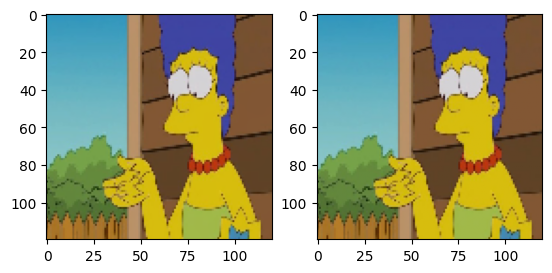

In [6]:
# Merge the reconstructed channels back into a single image
im_out = np.stack(im_out_channels, axis=-1)
im_out = np.clip(im_out, 0, 1)

# Display the results
plt.subplot(121)
plt.imshow(im_out)
plt.subplot(122)
plt.imshow(im)
plt.show()

In [7]:
print('Max error is: ', np.sqrt(((im_out - im) ** 2).max()))

Max error is:  7.60846941005866e-12


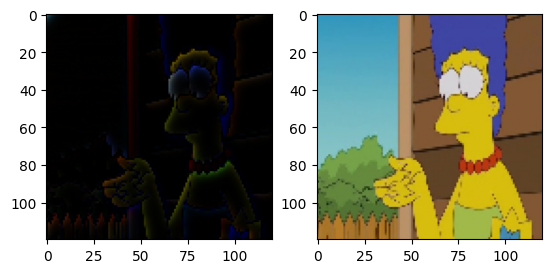

In [8]:
# Reconstruct each channel separately with different alpha
im_out_channels = [reconstruction(channel, alpha=1.5) for channel in im_channels]

# Merge the reconstructed channels back into a single image
im_out = np.stack(im_out_channels, axis=-1)
im_out = np.clip(im_out, 0, 1)

# Display the results
plt.subplot(121)
plt.imshow(im_out)
plt.subplot(122)
plt.imshow(im)
plt.show()

In [9]:
print('Max error is: ', np.sqrt(((im_out - im) ** 2).max()))

Max error is:  0.8532657206042134


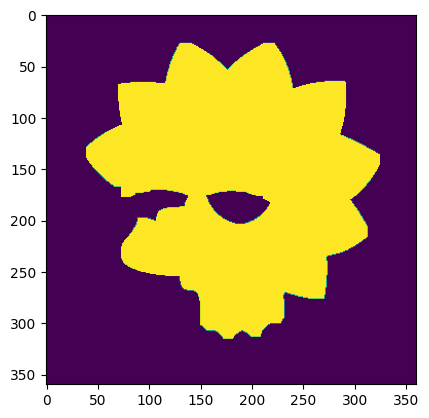

In [10]:
# Load images and resize
im = cv2.imread('img_1.jpg')
im = cv2.resize(im, (360, 360))
im2 = cv2.imread('img_2.png')
im2 = cv2.resize(im2, (360, 360))

# Create a mask for yellow color
hsv = cv2.cvtColor(im2, cv2.COLOR_BGR2HSV)
lower_yellow = np.array([20, 200, 200])
upper_yellow = np.array([50, 255, 255])

mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

# Dilate the mask
kernel = np.ones((4, 4), np.uint8)
mask = cv2.dilate(mask, kernel, iterations=3)
plt.imshow(mask)

In [11]:
# Define the Laplacian matrix function
def laplacian_matrix(n, m):
    mat_D = lil_matrix((m, m))
    mat_D.setdiag(-1, -1)
    mat_D.setdiag(4)
    mat_D.setdiag(-1, 1)

    mat_A = block_diag([mat_D] * n).tolil()
    mat_A.setdiag(-1, 1 * m)
    mat_A.setdiag(-1, -1 * m)

    return mat_A

In [12]:
# Compute the Laplacian matrix
mat_A = laplacian_matrix(360, 360)
laplacian = mat_A.tocsc()

In [13]:
# Update the matrix based on the mask
y_max, x_max = im.shape[:-1]
y_min, x_min = 0, 0
x_range = x_max - x_min
y_range = y_max - y_min

In [14]:
for y in range(1, y_range - 1):
    for x in range(1, x_range - 1):
        if mask[y, x] == 0:
            k = x + y * x_range
            mat_A[k, k] = 1
            mat_A[k, k + 1] = 0
            mat_A[k, k - 1] = 0
            mat_A[k, k + x_range] = 0
            mat_A[k, k - x_range] = 0
            
mat_A = mat_A.tocsc()

In [15]:
# Apply Poisson blending for each channel
mask_flat = mask.flatten()

In [16]:
for channel in range(im.shape[2]):
    source_flat = im2[y_min:y_max, x_min:x_max, channel].flatten()
    target_flat = im[y_min:y_max, x_min:x_max, channel].flatten()

    alpha = 1
    mat_b = laplacian.dot(source_flat) * alpha
    mat_b[mask_flat == 0] = target_flat[mask_flat == 0]

    x = spsolve(mat_A, mat_b)
    x = x.reshape((y_range, x_range))
    x = np.clip(x, 0, 255).astype('uint8')

    im[y_min:y_max, x_min:x_max, channel] = x

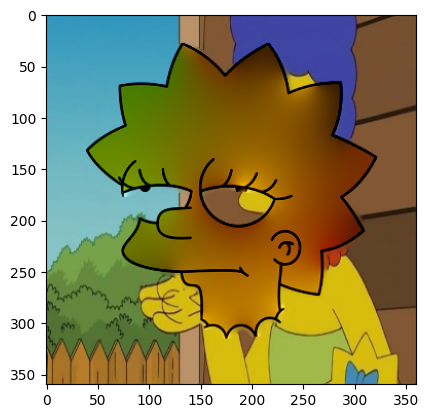

In [17]:
# Display the final image
plt.imshow(im[:, :, ::-1])
plt.show()